# LSTM for AQI forecasting

In [94]:
import numpy as np
import time
import json
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Reading data

In [124]:
#Local file
path = './datasets/'
object_name = 'seoul-air-quality.csv'
df = pd.read_csv(path + object_name)
df.head(5)

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [125]:
df.describe()

,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000
mean,113.000221,37.553484,126.989340,-0.001795,0.022519,0.017979,0.509197,43.708051,25.411995
std,7.211315,0.053273,0.078790,0.078832,0.115153,0.099308,0.405319,71.137342,43.924595
min,101.000000,37.452357,126.835151,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,53.000000,31.000000
max,125.000000,37.658774,127.136792,3.736000,38.445000,33.600000,71.700000,3586.000000,6256.000000


### Cleaning data

In [126]:
# Setting index
df['Measurement date'] = pd.to_datetime(df['Measurement date']).dt.strftime('%Y-%m-%d %H')
#df[['Dates','Hour']] = df['Measurement date'].str.split(' ',expand=True)


# Deleting co column
#df = df.drop(['Measurement date','Address','Latitude','Longitude'], axis = 1)
df = df.drop(['Address','Latitude','Longitude'], axis = 1)

# Select station
df = df.loc[df['Station code'] == 101]
df = df.drop(['Station code'], axis = 1)

# Sort
#df = df.sort_values(['Dates', 'Hour'])
df = df.sort_values(['Measurement date'])
#df = df.drop(['Hour'], axis = 1)

#df['Dates'] = pd.to_datetime(df['Dates'])
#df = df.set_index('Dates')
df = df.set_index('Measurement date')

df.head(15)

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-01-01 00,0.004,0.059,0.002,1.2,73.0,57.0
2017-01-01 01,0.004,0.058,0.002,1.2,71.0,59.0
2017-01-01 02,0.004,0.056,0.002,1.2,70.0,59.0
2017-01-01 03,0.004,0.056,0.002,1.2,70.0,58.0
2017-01-01 04,0.003,0.051,0.002,1.2,69.0,61.0
2017-01-01 05,0.003,0.046,0.002,1.1,70.0,61.0
2017-01-01 06,0.003,0.049,0.002,1.1,66.0,57.0
2017-01-01 07,0.003,0.045,0.002,1.0,71.0,60.0
2017-01-01 08,0.004,0.047,0.002,1.1,72.0,60.0


### Problem framing

To perform a AQI forecasting, we should perform the forecasting of each variable.

In [127]:
# Auxiliar functions series_to_supervised (Acknowledgement to Julia Ana for this code)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        """
            Convert series to supervised learning (source): 
            https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
        """
        n_vars = 1 if type(data) is list else data.shape[1]        
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [128]:
w_past = 30
w_forecasts = 30

reframed = series_to_supervised(df, w_past, w_forecasts) 
reframed

,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var5(t-30),var6(t-30),var1(t-29),var2(t-29),var3(t-29),var4(t-29),...,var3(t+28),var4(t+28),var5(t+28),var6(t+28),var1(t+29),var2(t+29),var3(t+29),var4(t+29),var5(t+29),var6(t+29)
Measurement date,,,,,,,,,,,,,,,,,,,,,
2017-01-02 06,0.004,0.059,0.002,1.2,73.0,57.0,0.004,0.058,0.002,1.2,...,0.012,0.9,76.0,57.0,0.006,0.052,0.011,0.9,75.0,53.0
2017-01-02 07,0.004,0.058,0.002,1.2,71.0,59.0,0.004,0.056,0.002,1.2,...,0.011,0.9,75.0,53.0,0.006,0.052,0.016,0.8,75.0,53.0
2017-01-02 08,0.004,0.056,0.002,1.2,70.0,59.0,0.004,0.056,0.002,1.2,...,0.016,0.8,75.0,53.0,0.006,0.056,0.013,0.8,71.0,48.0
2017-01-02 09,0.004,0.056,0.002,1.2,70.0,58.0,0.003,0.051,0.002,1.2,...,0.013,0.8,71.0,48.0,0.007,0.045,0.020,0.6,76.0,53.0
2017-01-02 10,0.003,0.051,0.002,1.2,69.0,61.0,0.003,0.046,0.002,1.1,...,0.020,0.6,76.0,53.0,0.006,0.044,0.019,0.6,59.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 14,0.004,0.035,0.007,0.7,45.0,30.0,0.004,0.035,0.009,0.7,...,0.014,0.5,25.0,19.0,0.003,0.026,0.014,0.5,26.0,19.0
2019-12-30 15,0.004,0.035,0.009,0.7,45.0,27.0,0.004,0.032,0.011,0.6,...,0.014,0.5,26.0,19.0,0.003,0.024,0.014,0.4,27.0,19.0
2019-12-30 16,0.004,0.032,0.011,0.6,47.0,31.0,0.004,0.034,0.011,0.8,...,0.014,0.4,27.0,19.0,0.003,0.014,0.021,0.4,23.0,18.0


In [129]:
# Some variables
forecast_feature = 'PM2.5'

n_features = 5
n_past, n_forecasts = w_past, w_forecasts
n_features_out = 1
n_obs = n_features * n_past

w_train = (0, 20000)
w_validation = (20001, 25846)
w_test = (20001, 25846)

# defining X and Y
n_obs_in = (n_features * n_past)
n_obs_out = (n_features_out * n_forecasts)

X = reframed.values[:, :n_obs_in]
y = reframed.filter(regex='var5', axis=1)
y = y.iloc[:,-n_forecasts:].values

print(X.shape, y.shape)

(25846, 150) (25846, 30)


In [130]:
# MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y)

In [131]:
# Split X, y
X_train = X[w_train[0]:w_train[1] +1, :n_obs]
y_train = y[w_train[0]:w_train[1] +1 , :] 
X_val = X[w_validation[0]:w_validation[1] +1, :n_obs]
y_val = y[w_validation[0]:w_validation[1] +1, :]
X_test = X[w_test[0]:w_test[1] +1, :n_obs]
y_test= y[w_test[0]:w_test[1] +1, :] 

print('Shape of splits:')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape,'\n')

Shape of splits:
(20001, 150) (20001, 30) (5845, 150) (5845, 30) (5845, 150) (5845, 30) 



In [132]:
 pd.DataFrame(X[w_validation[0]:w_validation[1] +1, :n_obs])

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.004,0.054,0.042,0.7,62.0,32.0,0.004,0.058,0.033,0.7,...,0.067,0.5,58.0,36.0,0.005,0.031,0.047,0.6,52.0,30.0
1,0.004,0.058,0.033,0.7,66.0,35.0,0.005,0.057,0.030,0.7,...,0.047,0.6,52.0,30.0,0.005,0.046,0.027,0.6,51.0,30.0
2,0.005,0.057,0.030,0.7,68.0,38.0,0.004,0.052,0.029,0.7,...,0.027,0.6,51.0,30.0,0.005,0.054,0.013,0.6,47.0,28.0
3,0.004,0.052,0.029,0.7,61.0,39.0,0.005,0.044,0.031,0.6,...,0.013,0.6,47.0,28.0,0.004,0.043,0.018,0.5,39.0,25.0
4,0.005,0.044,0.031,0.6,53.0,35.0,0.005,0.051,0.022,0.6,...,0.018,0.5,39.0,25.0,0.004,0.045,0.013,0.5,34.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,0.004,0.035,0.007,0.7,45.0,30.0,0.004,0.035,0.009,0.7,...,0.002,0.7,28.0,21.0,0.004,0.041,0.003,0.8,30.0,23.0
5841,0.004,0.035,0.009,0.7,45.0,27.0,0.004,0.032,0.011,0.6,...,0.003,0.8,30.0,23.0,0.004,0.048,0.003,1.1,34.0,25.0
5842,0.004,0.032,0.011,0.6,47.0,31.0,0.004,0.034,0.011,0.8,...,0.003,1.1,34.0,25.0,0.003,0.047,0.004,1.0,39.0,30.0
5843,0.004,0.034,0.011,0.8,46.0,29.0,0.004,0.034,0.011,0.7,...,0.004,1.0,39.0,30.0,0.003,0.051,0.004,0.9,45.0,32.0


In [133]:
# Using the X,y scalers, scale the data
X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
X_val, y_val = X_scaler.transform(X_val), y_scaler.transform(y_val)
X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)

In [134]:
# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_past, n_features))
X_val = X_val.reshape((X_val.shape[0], n_past, n_features))
X_test = X_test.reshape((X_test.shape[0], n_past, n_features))
print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

Re-shaped for LSTM:
(20001, 30, 5) (20001, 30) (5845, 30, 5) (5845, 30) (5845, 30, 5) (5845, 30)


### Model 

In [135]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU

In [136]:
# Design network
#input shape = (loockback, num_features)
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(GRU(50,activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu',return_sequences=True))
#model.add(GRU(50, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
#model.add(GRU(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_forecasts))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 50)            11200     
                                                                 
 dropout_9 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 30)               

In [137]:
# Training
start_time = time.time()
history = model.fit(X_train, y_train, 
                    epochs=25, batch_size=10, 
                    validation_data=(X_val, y_val), 
                    verbose=2, shuffle=False)
training_time = time.time() - start_time

Epoch 1/25
2001/2001 - 72s - loss: 0.0336 - val_loss: 0.0312 - 72s/epoch - 36ms/step
Epoch 2/25
2001/2001 - 71s - loss: 0.0330 - val_loss: 0.0313 - 71s/epoch - 35ms/step
Epoch 3/25
2001/2001 - 71s - loss: 0.0330 - val_loss: 0.0313 - 71s/epoch - 35ms/step
Epoch 4/25
2001/2001 - 68s - loss: 0.0330 - val_loss: 0.0312 - 68s/epoch - 34ms/step
Epoch 5/25
2001/2001 - 71s - loss: 0.0330 - val_loss: 0.0313 - 71s/epoch - 35ms/step
Epoch 6/25
2001/2001 - 68s - loss: 0.0330 - val_loss: 0.0313 - 68s/epoch - 34ms/step
Epoch 7/25
2001/2001 - 72s - loss: 0.0330 - val_loss: 0.0312 - 72s/epoch - 36ms/step
Epoch 8/25
2001/2001 - 66s - loss: 0.0330 - val_loss: 0.0313 - 66s/epoch - 33ms/step
Epoch 9/25
2001/2001 - 68s - loss: 0.0330 - val_loss: 0.0312 - 68s/epoch - 34ms/step
Epoch 10/25
2001/2001 - 66s - loss: 0.0330 - val_loss: 0.0313 - 66s/epoch - 33ms/step
Epoch 11/25
2001/2001 - 70s - loss: 0.0332 - val_loss: 0.0307 - 70s/epoch - 35ms/step
Epoch 12/25
2001/2001 - 79s - loss: 0.0331 - val_loss: 0.0312 -

In [138]:
# Saving model
date = dt.now().date()
model.save(f'models/LSTM{date}.h5')

/tmp/ipykernel_9169/4042831328.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color='b', linestyle='-')


(0.0, 25.0)

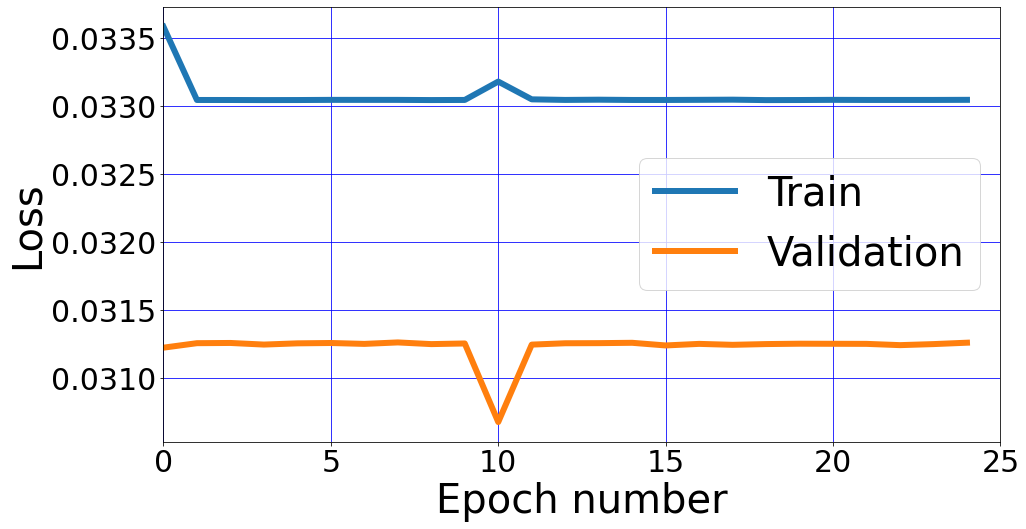

In [139]:
# Evaluation

figure=plt.figure(figsize=(15, 8))

# plot history
plt.plot(history.history['loss'], label='Train', linewidth=6)
plt.plot(history.history['val_loss'], label='Validation', linewidth=6)
plt.legend()

ax = plt.gca()
ax.set_facecolor((1.0, 1.0, 1.0))
ax.margins(x=0)
ax.grid(b=True, which='major', color='b', linestyle='-')
# ax.yaxis.set_major_locator(mtick.LinearLocator(5))
ax.tick_params(axis='both', which='major', direction='out', labelsize=30)
ax.set_xlabel('Epoch number', fontsize=40)
ax.set_ylabel('Loss', fontsize=40)
ax.legend( fontsize=40, loc='best')
ax.grid(True)


plt.xlim([0,25])
#ax.set_ylim([0,0.1])
# figure.savefig(f'figures/training-loss.png', bbox_inches='tight')
# figure.savefig(f'figures/training-loss.svg', bbox_inches='tight')

### Predicton

In [140]:
# Reshape X_test[0] into 3D
x_input = X_test[0].reshape((1, n_past, n_features))
print ('x_input shape: ',x_input.shape)

# Make the prediction
yhat = model.predict(x_input)

x_input shape:  (1, 30, 5)


In [141]:
 print ('yhat shape:', yhat[0].shape)

# Invert the scaling for yhat using the y_scaler from above
inv_yhat = y_scaler.inverse_transform(yhat)
inv_yhat

yhat shape: (30,)


array([[35.842724, 35.84634 , 36.0531  , 36.160065, 36.12815 , 36.023735,
        36.043392, 36.002415, 35.97085 , 35.89619 , 35.917114, 35.95514 ,
        36.220085, 36.21561 , 36.25831 , 36.214024, 36.292953, 36.26877 ,
        36.211487, 36.16718 , 36.23582 , 36.028458, 36.244766, 36.284847,
        36.28866 , 36.211227, 36.198566, 36.274624, 36.090286, 36.146313]],
      dtype=float32)

In [142]:
# Checking the shape of y_test[0]
print ('y_test shape:' , y_test[0].shape)

# Reshape y_test
inv_y = y_scaler.inverse_transform(y_test)

inv_y = inv_y[0].reshape(1, inv_y[0].shape[0])
print('inv_y shape:', inv_y.shape)

y_test shape: (30,)
inv_y shape: (1, 30)


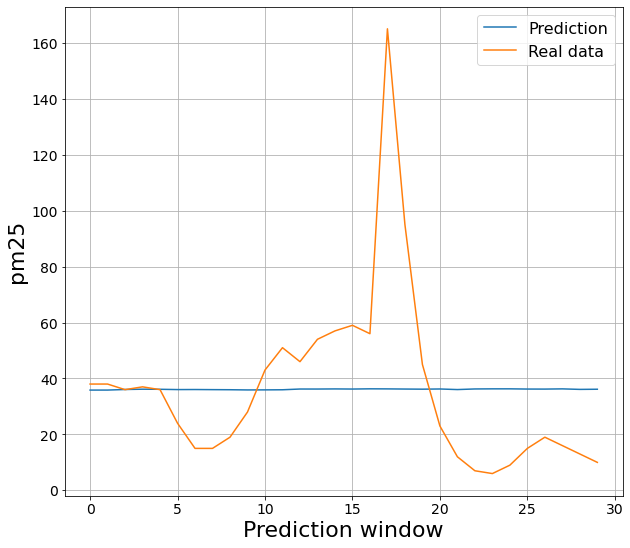

In [143]:
plt.figure(figsize=(10,9))
plt.plot(inv_yhat[0], label='Prediction')
plt.plot(inv_y[0], label='Real data')
plt.xlabel('Prediction window', fontsize=22)
plt.ylabel('pm25', fontsize=22)
# plt.rc('axes', labelsize=1)    # fontsize of the x and y labels
plt.rcParams.update({'font.size': 14})
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [144]:
mse = mean_squared_error(y_test[0], yhat[0])
print ('Mean Squared Error:',mse)

mae = mean_absolute_error(y_test[0], yhat[0])
print ('Mean Absolute Error:',mae)

Mean Squared Error: 0.003637031288353157
Mean Absolute Error: 0.04033214714904128


In [145]:
X_test_plot = df.iloc[w_validation[0]:w_validation[1] +1][:n_obs][forecast_feature] # we take initial df + filter index of validation 

In [146]:
# Create dataframe with prediction
forecast = pd.DataFrame()
forecast[forecast_feature] = inv_yhat[0] 
forecast[forecast_feature][forecast[forecast_feature]<0]=0   # min value is 0 
# we add 72h to the last index of X_test_plot(used for the prediction)
forecast.index = pd.date_range(start=X_test_plot.index.max(),periods=w_forecasts,freq='H')  

In [147]:
print(X_test_plot)

print(forecast)

plt.figure(figsize=(10,9))
plt.plot(X_test_plot,label='actual')
plt.plot(forecast, label='forecast')
plt.legend()
plt.show()

Measurement date
2019-04-23 17    32.0
2019-04-23 18    35.0
2019-04-23 19    38.0
2019-04-23 20    39.0
2019-04-23 21    35.0
                 ... 
2019-04-29 18    14.0
2019-04-29 19    18.0
2019-04-29 20    18.0
2019-04-29 21    21.0
2019-04-29 22    21.0
Name: PM2.5, Length: 150, dtype: float64
                         PM2.5
2019-04-29 22:00:00  35.842724
2019-04-29 23:00:00  35.846340
2019-04-30 00:00:00  36.053101
2019-04-30 01:00:00  36.160065
2019-04-30 02:00:00  36.128151
2019-04-30 03:00:00  36.023735
2019-04-30 04:00:00  36.043392
2019-04-30 05:00:00  36.002415
2019-04-30 06:00:00  35.970852
2019-04-30 07:00:00  35.896191
2019-04-30 08:00:00  35.917114
2019-04-30 09:00:00  35.955139
2019-04-30 10:00:00  36.220085
2019-04-30 11:00:00  36.215611
2019-04-30 12:00:00  36.258308
2019-04-30 13:00:00  36.214024
2019-04-30 14:00:00  36.292953
2019-04-30 15:00:00  36.268768
2019-04-30 16:00:00  36.211487
2019-04-30 17:00:00  36.167179
2019-04-30 18:00:00  36.235821
2019-04-30 19:00:0

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'UnitData'